# utilizzo di più istanze sugli algoritmi di clustering


## **Definizione delle funzioni e classi:**



In [151]:
# Libreries
import networkx as nx
import matplotlib.pyplot as plt
import community as community_louvain 
from node2vec import Node2Vec
from sklearn.cluster import KMeans
from collections import defaultdict
import itertools
import time,random
import numpy as np
from copy import deepcopy
import copy
from collections import deque



# Louvain


In [152]:
def plot_graph(graph, title, subplot_position=None, filename=None, colors=None):
    plt.subplot(subplot_position) if subplot_position else plt.figure()
    pos = nx.spring_layout(graph, seed=42)
    labels = {node: str(node) for node in graph.nodes()}
    node_colors = {node: 'skyblue' for node in graph.nodes()}

    if colors:
        color_cycle = itertools.cycle(plt.cm.tab10.colors)
        for i, cluster in enumerate(colors):
            color = next(color_cycle)
            for node in cluster:
                node_colors[int(node)] = color

    nx.set_node_attributes(graph, node_colors, 'color')

    nx.draw(graph, pos, with_labels=True, labels=labels, node_size=1000, node_color=list(node_colors.values()), 
            font_size=12, font_color='black', edge_color='gray', edgecolors='black', linewidths=1)

    plt.title(title)
    if filename and not subplot_position:
        plt.savefig(filename)
    if not subplot_position:
        plt.show()

class Graph:
    def __init__(self):
        self.grafo = {}

    def aggiungi_vertice(self, vertice):
        if vertice not in self.grafo:
            self.grafo[vertice] = []

    def aggiungi_arco(self, u, v):
        if u in self.grafo and v in self.grafo:
            self.grafo[u].append(v)
            self.grafo[v].append(u)

    def rimuovi_vertice(self, vertice):
        if vertice in self.grafo:
            self.grafo.pop(vertice, None)
            for nodo, adiacenti in self.grafo.items():
                if vertice in adiacenti:
                    adiacenti.remove(vertice)


    def stampa_grafo(self):
        for vertice in self.grafo:
            adiacenti = ", ".join(str(v) for v in self.grafo[vertice])
            print(f"{vertice} -> {adiacenti}")

def converti_grafo_personalizzato_in_networkx(grafo_personalizzato):
    G = nx.Graph()
    for vertice, adiacenti in grafo_personalizzato.grafo.items():
        G.add_node(vertice)
        for adiacente in adiacenti:
            G.add_edge(vertice, adiacente)
    return G

    
def divide_into_clusters(graph):
    partition = community_louvain.best_partition(graph)
    clusters = defaultdict(list)
    for node, cluster_index in partition.items():
        clusters[cluster_index].append(node)
    return list(clusters.values())

def divide_into_clusters_fixed_k(graph, k):
    # Get the initial division into clusters
    clusters = divide_into_clusters(graph)

    # Se ci sono già k cluster, restituirli
    if len(clusters) == k:
        return clusters

    # Se ci sono più di k cluster, combinare quelli più piccoli
    while len(clusters) > k:
        # Trovare il cluster più piccolo
        smallest_cluster = min(clusters, key=len)
        clusters.remove(smallest_cluster)
        # Trovare il cluster con cui il più piccolo condivide il maggior numero di archi.
        max_shared_edges = 0
        best_cluster_to_combine = None
        for cluster in clusters:
            shared_edges = sum(1 for node in smallest_cluster if set(graph.neighbors(node)) & set(cluster))
            if shared_edges > max_shared_edges:
                max_shared_edges = shared_edges
                best_cluster_to_combine = cluster
        # Combine the clusters
        best_cluster_to_combine.extend(smallest_cluster)

    # Se ci sono meno di k cluster, dividere quelli più grandi
    while len(clusters) < k:
        # Find the largest cluster
        largest_cluster = max(clusters, key=len)
        clusters.remove(largest_cluster)
        # Trova il nodo con il maggior numero di connessioni al di fuori del cluster
        max_external_connections = 0
        best_node_to_move = None
        for node in largest_cluster:
            external_connections = sum(1 for neighbor in graph.neighbors(node) if neighbor not in largest_cluster)
            if external_connections > max_external_connections:
                max_external_connections = external_connections
                best_node_to_move = node
        # Create a new cluster with this node
        new_cluster = [best_node_to_move]
        if best_node_to_move in largest_cluster:
            largest_cluster.remove(best_node_to_move)
        #largest_cluster.remove(best_node_to_move)
        # Spostare i nodi collegati al nodo del nuovo cluster dal vecchio al nuovo cluster.
        for node in list(largest_cluster):  # Copiare l'elenco per evitare problemi durante la rimozione degli elementi
            if best_node_to_move in graph.neighbors(node):
                new_cluster.append(node)
                largest_cluster.remove(node)
        # Add the modified and new clusters
        clusters.append(largest_cluster)
        clusters.append(new_cluster)

    # Ensure that no cluster is empty
    clusters = [cluster for cluster in clusters if cluster]

    return clusters


def calculate_multicut_size(graph, clusters):
    multicut_size = 0
    for cluster in clusters:
        for node in cluster:
            for neighbor in graph.neighbors(node):
                if neighbor not in cluster:
                    multicut_size += 1
    # Poiché ogni arco viene contato due volte (una volta per ogni estremo), dividi per 2
    return multicut_size // 2


def è_ammissibile(grafo, clusters, k):
    # Vincolo 2: numero di sottografi = k
    if len(clusters) != k:
        return False, "Vincolo 2 violato: il numero di sottografi non è k."

  # Vincolo 1: Ogni vertice in uno e solo uno dei sottografi
    tutti_nodi = set(grafo.nodes())
    union_clusters = set().union(*clusters)
    missing_nodi = tutti_nodi - union_clusters
    extra_nodi = union_clusters - tutti_nodi

    if missing_nodi:
        return False, f"Vincolo 1 violato: i nodi {missing_nodi} non sono presenti in nessun cluster."
    elif extra_nodi:
        return False, f"Vincolo 1 violato: i nodi {extra_nodi} sono presenti in più cluster."


    # Vincolo 3: verifica l'integrità e la connettività dei cluster
    for cluster in clusters:
        if not cluster:
            return False, "Vincolo 3 violato: cluster vuoto."
        

    return True, "Ammissibile"

""" 
def correggi_ammissibilità(grafo, clusters):
    # Per ogni coppia di cluster
    for i in range(len(clusters)):
        for j in range(i+1, len(clusters)):
            cluster1 = clusters[i]
            cluster2 = clusters[j]
            nodi_da_spostare = []
            # Cerca nodi nel cluster1 che hanno più vicini nel cluster2 che nel cluster1
            for nodo in cluster1:
                vicini_cluster1 = sum(1 for vicino in grafo.neighbors(nodo) if vicino in cluster1)
                vicini_cluster2 = sum(1 for vicino in grafo.neighbors(nodo) if vicino in cluster2)
                if vicini_cluster2 > vicini_cluster1:
                    nodi_da_spostare.append(nodo)
            # Sposta i nodi da cluster1 a cluster2
            for nodo in nodi_da_spostare:
                cluster1.remove(nodo)
                cluster2.append(nodo)

    # Gestisci clusters vuoti
    cluster_vuoti = [cluster for cluster in clusters if not cluster]
    while cluster_vuoti:
        largest_cluster = max(clusters, key=len, default=[])
        if not largest_cluster:
            raise ValueError("Tutti i cluster sono vuoti, il che non dovrebbe mai accadere!")
        
        empty_cluster = cluster_vuoti.pop()  # estrai un cluster vuoto

        # Trova il nodo con il minor numero di connessioni nel cluster più grande
        if largest_cluster:
            node_to_move = min(largest_cluster, key=lambda n: len(list(grafo.neighbors(n))), default=None)
            if node_to_move:
                largest_cluster.remove(node_to_move)
                empty_cluster.append(node_to_move)
            else:
                raise ValueError("Nessun nodo da spostare trovato!")

        # Aggiorna la lista dei cluster vuoti
        cluster_vuoti = [cluster for cluster in clusters if not cluster]

    return clusters """





' \ndef correggi_ammissibilità(grafo, clusters):\n    # Per ogni coppia di cluster\n    for i in range(len(clusters)):\n        for j in range(i+1, len(clusters)):\n            cluster1 = clusters[i]\n            cluster2 = clusters[j]\n            nodi_da_spostare = []\n            # Cerca nodi nel cluster1 che hanno più vicini nel cluster2 che nel cluster1\n            for nodo in cluster1:\n                vicini_cluster1 = sum(1 for vicino in grafo.neighbors(nodo) if vicino in cluster1)\n                vicini_cluster2 = sum(1 for vicino in grafo.neighbors(nodo) if vicino in cluster2)\n                if vicini_cluster2 > vicini_cluster1:\n                    nodi_da_spostare.append(nodo)\n            # Sposta i nodi da cluster1 a cluster2\n            for nodo in nodi_da_spostare:\n                cluster1.remove(nodo)\n                cluster2.append(nodo)\n\n    # Gestisci clusters vuoti\n    cluster_vuoti = [cluster for cluster in clusters if not cluster]\n    while cluster_vuo

# Greedy

In [153]:
def divide_into_clusters_greedy(graph, k):
    nodes = list(graph.nodes())
    clusters = [[node] for node in nodes]

    # Continua a unire i cluster finché non raggiungi il numero di cluster desiderato
    while len(clusters) > k:
        min_multicut_size = float('inf')
        cluster_to_merge_index = -1

        # Per ogni coppia di cluster, calcola la taglia del multicut se fossero uniti
        for i in range(len(clusters)):
            for j in range(i+1, len(clusters)):
                new_cluster = clusters[i] + clusters[j]
                new_multicut_size = calcola_dimensione_multicut(graph, clusters[:i] + [new_cluster] + clusters[i+1:j] + clusters[j+1:])

                # Se unire questi due cluster produce la taglia di multicut più piccola finora, tieni traccia di essi
                if new_multicut_size < min_multicut_size:
                    min_multicut_size = new_multicut_size
                    cluster_to_merge_index = (i, j)

        # Unisci i due cluster che producono la taglia di multicut più piccola
        i, j = cluster_to_merge_index
        new_cluster = clusters[i] + clusters[j]
        clusters = clusters[:i] + [new_cluster] + clusters[i+1:j] + clusters[j+1:]

    return clusters

def è_ammissibile(grafo, clusters, k):
    # Vincolo 2: numero di sottografi = k
    if len(clusters) != k:
        return False, "Vincolo 2 violato: il numero di sottografi non è k."

  # Vincolo 1: Ogni vertice in uno e solo uno dei sottografi
    tutti_nodi = set(grafo.nodes())
    union_clusters = set().union(*clusters)
    missing_nodi = tutti_nodi - union_clusters
    extra_nodi = union_clusters - tutti_nodi

    if missing_nodi:
        return False, f"Vincolo 1 violato: i nodi {missing_nodi} non sono presenti in nessun cluster."
    elif extra_nodi:
        return False, f"Vincolo 1 violato: i nodi {extra_nodi} sono presenti in più cluster."


    # Vincolo 3: verifica l'integrità e la connettività dei cluster
    for cluster in clusters:
        if not cluster:
            return False, "Vincolo 3 violato: cluster vuoto."
        

    return True, "Ammissibile"
   


def calcola_dimensione_multicut(grafo, clusters):
    dimensione_multicut = 0
    for u, v in grafo.edges():
        if not any(u in cluster and v in cluster for cluster in clusters):
            dimensione_multicut += 1  
    return dimensione_multicut




# Algoritmi genetici

Utilizzare gli algoritmi genetici (GA) per risolvere il problema di clustering può richiedere alcune decisioni di design:

- Codifica: come rappresentare una soluzione come un individuo in una popolazione.
- Funzione di fitness: come valutare la bontà di una soluzione.
- Selezione: come selezionare gli individui per la riproduzione.
- Crossover (ricombinazione): come combinare due individui per produrre un nuovo individuo.
- Mutazione: come introdurre piccole variazioni in un individuo.
  
Riorganizzando il codice per utilizzare gli algoritmi genetici:

- Codifica: ogni individuo è una lista di lunghezza uguale al numero di nodi nel grafo, dove l'elemento i-esimo rappresenta l'ID del cluster per il nodo i.

- Funzione di fitness: la funzione di fitness può essere basata sulla dimensione del multicut. Valori più bassi sono migliori.

- Selezione: utilizziamo la selezione della ruota della roulette.

- Crossover: utilizziamo un crossover a punto singolo.

- Mutazione: cambiamo l'ID del cluster di un nodo in modo casuale.



Per ripristinare l'ammissibilità, è necessario seguire una procedura dopo la mutazione per garantire che tutti i vincoli siano rispettati. Una procedura potrebbe essere:

Assicurarsi che ogni individuo abbia esattamente k clusters.
Assicurarsi che ogni nodo del grafo sia presente in uno ed esattamente un cluster.
Assicurarsi che ogni cluster sia connesso.

In [154]:
import random
import bisect
import networkx as nx

def calcola_dimensione_multicut(grafo, individual):
    node_to_cluster = {node: cluster for cluster, nodes in enumerate(individual) for node in nodes}
    dimensione_multicut = 0
    for u, v in grafo.edges():
        if node_to_cluster[u] == node_to_cluster[v]:
            continue
        dimensione_multicut += 1
    return dimensione_multicut

def init_population(size, num_nodes, k):
    return [[random.randint(0, k-1) for _ in range(num_nodes)] for _ in range(size)]

def fitness(individual, graph, k):
    clusters = [[] for _ in range(max(individual) + 1)]
    for i, cluster_id in enumerate(individual):
        clusters[cluster_id].append(i)
    
    fitness_val = calcola_dimensione_multicut(graph, clusters)
    
    # Penalizzazione per soluzioni non ammissibili
    if not è_ammissibile(graph, clusters, k):
        fitness_val += 1e6 # Una penalizzazione molto grande
    
    return fitness_val


def roulette_wheel_selection(population, fitness_values):
    cumulative_fitness = [sum(fitness_values[:i+1]) for i in range(len(fitness_values))]
    pick = random.uniform(0, cumulative_fitness[-1])
    chosen_index = bisect.bisect_left(cumulative_fitness, pick)
    return population[chosen_index]

def crossover(parent1, parent2):
    idx = random.randint(0, len(parent1) - 1)
    child1 = parent1[:idx] + parent2[idx:]
    child2 = parent2[:idx] + parent1[idx:]
    return child1, child2

def mutate(individual, k):
    idx = random.randint(0, len(individual) - 1)
    new_cluster = random.randint(0, k-1)
    while new_cluster == individual[idx]:
        new_cluster = random.randint(0, k-1)
    individual[idx] = new_cluster

def genetic_algorithm(graph, k, pop_size=100, gen_count=1000, mutation_rate=0.01):
    population = init_population(pop_size, len(graph.nodes()), k)
    fitness_values = [fitness(ind, graph, k) for ind in population]
    elitism_size = int(0.10 * len(population))
    
    for gen in range(gen_count):
        new_population = []
        elite_indices = sorted(range(len(fitness_values)), key=lambda x: fitness_values[x])[:elitism_size]
        
        for elite_index in elite_indices:
            new_population.append(population[elite_index])
            
        while len(new_population) < pop_size:
            parent1 = roulette_wheel_selection(population, fitness_values)
            parent2 = roulette_wheel_selection(population, fitness_values)
            child1, child2 = crossover(parent1, parent2)
            
            if random.random() < mutation_rate:
                mutate(child1, k)
            if random.random() < mutation_rate:
                mutate(child2, k)
            new_population.extend([child1, child2])

        fitness_values = [fitness(ind, graph, k) for ind in population]

        population = new_population
    
    best_individual = min(population, key=lambda ind: fitness(ind, graph, k))
    clusters = [[] for _ in range(max(best_individual) + 1)]
    for i, cluster_id in enumerate(best_individual):
        clusters[cluster_id].append(i)
    return clusters

def è_ammissibile(grafo, clusters, k):
    # Vincolo 2: numero di sottografi = k
    if len(clusters) != k:
        return False

 # Vincolo 1: Ogni vertice in uno e solo uno dei sottografi
    tutti_nodi = set(grafo.nodes())
    union_clusters = set().union(*clusters)
    missing_nodi = tutti_nodi - union_clusters
    extra_nodi = union_clusters - tutti_nodi

    if missing_nodi:
        return False, f"Vincolo 1 violato: i nodi {missing_nodi} non sono presenti in nessun cluster."
    elif extra_nodi:
        return False, f"Vincolo 1 violato: i nodi {extra_nodi} sono presenti in più cluster."


    return True, "Ammisibile"



# Greedy

In [155]:
import networkx as nx
import matplotlib.pyplot as plt
import itertools
import time

def plot_graph(graph, title, subplot_position=None, filename=None, colors=None):
    plt.subplot(subplot_position) if subplot_position else plt.figure()
    pos = nx.spring_layout(graph, seed=42)
    labels = {node: str(node) for node in graph.nodes()}
    node_colors = {node: 'skyblue' for node in graph.nodes()}

    if colors:
        color_cycle = itertools.cycle(plt.cm.tab10.colors)
        for i, cluster in enumerate(colors):
            color = next(color_cycle)
            for node in cluster:
                node_colors[int(node)] = color

    nx.set_node_attributes(graph, node_colors, 'color')

    nx.draw(graph, pos, with_labels=True, labels=labels, node_size=1000, node_color=list(node_colors.values()), 
            font_size=12, font_color='black', edge_color='gray', edgecolors='black', linewidths=1)

    plt.title(title)
    if filename and not subplot_position:
        plt.savefig(filename)
    if not subplot_position:
        plt.show()

class Graph:
    def __init__(self):
        self.grafo = {}

    def aggiungi_vertice(self, vertice):
        if vertice not in self.grafo:
            self.grafo[vertice] = []

    def aggiungi_arco(self, u, v):
        if u in self.grafo and v in self.grafo:
            self.grafo[u].append(v)
            self.grafo[v].append(u)

    def rimuovi_vertice(self, vertice):
        if vertice in self.grafo:
            self.grafo.pop(vertice, None)
            for nodo, adiacenti in self.grafo.items():
                if vertice in adiacenti:
                    adiacenti.remove(vertice)


    def stampa_grafo(self):
        for vertice in self.grafo:
            adiacenti = ", ".join(str(v) for v in self.grafo[vertice])
            print(f"{vertice} -> {adiacenti}")

def converti_grafo_personalizzato_in_networkx(grafo_personalizzato):
    G = nx.Graph()
    for vertice, adiacenti in grafo_personalizzato.grafo.items():
        G.add_node(vertice)
        for adiacente in adiacenti:
            G.add_edge(vertice, adiacente)
    return G



def divide_into_clusters_greedy(graph, k):
    G_temp = graph.copy()
    
    # Se il grafo non ha pesi, calcoliamo la centralità degli archi come criterio
    if not nx.get_edge_attributes(G_temp, 'weight'): 
        centrality = nx.edge_betweenness_centrality(G_temp) # Calcola la centralità degli archi per ogni arco del grafo G_temp e restituisce un dizionario con gli archi come chiavi e la centralità degli archi come valori.
        nx.set_edge_attributes(G_temp, centrality, 'weight')  # Imposta gli attributi degli archi del grafo G_temp con i valori del dizionario centrality.

    edges_sorted = sorted(G_temp.edges(data=True), key=lambda x: x[2]['weight'], reverse=True) # Ordina gli archi del grafo G_temp in ordine decrescente in base al peso.
    
    while len(list(nx.connected_components(G_temp))) < k and edges_sorted:  #controllo: Se il numero di componenti connesse in G_temp è inferiore a k e se ci sono ancora archi nell'elenco edges_sorted da considerare per la rimozione.
        e = edges_sorted.pop(0) # Rimuove e restituisce l'elemento all'indice specificato dall'elenco edges_sorted. L'indice predefinito è -1, il che significa che l'ultimo elemento viene rimosso e restituito.
        G_temp.remove_edge(*e[:2]) # Rimuove l'arco tra i nodi e[0] e e[1] dal grafo G_temp.

        if len(list(nx.connected_components(G_temp))) > k:
            G_temp.add_edge(*e[:2])
            break

    clusters = list(nx.connected_components(G_temp))

    # Se abbiamo meno di k cluster, distribuisci i nodi rimanenti
    while len(clusters) < k:
        # Per semplicità, ho aggiunto nodi in modo casuale
        #  i nodi vengono aggiunti al primo cluster fino a raggiungere k clusters. La scelta del nodo da aggiungere è casuale
        
        # set(itertools.chain.from_iterable(clusters)) l'espressione combina tutti gli elementi dei clusters in un unico set. 
        # next(iter(set(graph.nodes()) prendere "un nodo qualsiasi" dal grafo che non è già in un cluster
        node_to_add = next(iter(set(graph.nodes()) - set(itertools.chain.from_iterable(clusters)))) # Prendi un nodo che non è ancora stato aggiunto
        clusters[0].add(node_to_add)

    return clusters


def è_ammissibile(grafo, clusters, k):
    # Vincolo 2: numero di sottografi = k
    if len(clusters) != k:
        return False

 # Vincolo 1: Ogni vertice in uno e solo uno dei sottografi
    tutti_nodi = set(grafo.nodes())
    union_clusters = set().union(*clusters)
    missing_nodi = tutti_nodi - union_clusters
    extra_nodi = union_clusters - tutti_nodi

    if missing_nodi:
        return False, f"Vincolo 1 violato: i nodi {missing_nodi} non sono presenti in nessun cluster."
    elif extra_nodi:
        return False, f"Vincolo 1 violato: i nodi {extra_nodi} sono presenti in più cluster."


    # Vincolo 3 è implicito nella rappresentazione
    for cluster in clusters:
        if not cluster:  # Controlla se il cluster è vuoto
            return False
        sottografo = grafo.subgraph(cluster)
        if not nx.is_connected(sottografo):
            return False

    return True


# 
def calcola_dimensione_multicut(grafo, clusters):
    dimensione_multicut = 0
    for u, v in grafo.edges():
        if not any(u in cluster and v in cluster for cluster in clusters):
            dimensione_multicut += 1  
    return dimensione_multicut






# Greedy con Ricerca Locale


In [156]:
import networkx as nx
import matplotlib.pyplot as plt
import community as community_louvain 
import itertools
import time

def plot_graph(graph, title, subplot_position=None, filename=None, colors=None):
    plt.subplot(subplot_position) if subplot_position else plt.figure()
    pos = nx.spring_layout(graph, seed=42)
    labels = {node: str(node) for node in graph.nodes()}
    node_colors = {node: 'skyblue' for node in graph.nodes()}

    if colors:
        color_cycle = itertools.cycle(plt.cm.tab10.colors)
        for i, cluster in enumerate(colors):
            color = next(color_cycle)
            for node in cluster:
                node_colors[int(node)] = color

    nx.set_node_attributes(graph, node_colors, 'color')

    nx.draw(graph, pos, with_labels=True, labels=labels, node_size=1000, node_color=list(node_colors.values()), 
            font_size=12, font_color='black', edge_color='gray', edgecolors='black', linewidths=1)

    plt.title(title)
    if filename and not subplot_position:
        plt.savefig(filename)
    if not subplot_position:
        plt.show()

class Graph:
    def __init__(self):
        self.grafo = {}

    def aggiungi_vertice(self, vertice):
        if vertice not in self.grafo:
            self.grafo[vertice] = []

    def aggiungi_arco(self, u, v):
        if u in self.grafo and v in self.grafo:
            self.grafo[u].append(v)
            self.grafo[v].append(u)

    def rimuovi_vertice(self, vertice):
        if vertice in self.grafo:
            self.grafo.pop(vertice, None)
            for nodo, adiacenti in self.grafo.items():
                if vertice in adiacenti:
                    adiacenti.remove(vertice)


    def stampa_grafo(self):
        for vertice in self.grafo:
            adiacenti = ", ".join(str(v) for v in self.grafo[vertice])
            print(f"{vertice} -> {adiacenti}")
 
 
 



def evaluate_solution(solution, graph): 
    counted_edges = set() # Inizializza un insieme vuoto di archi contati
    for cluster in solution: # Per ogni cluster nella soluzione 
        if not isinstance(cluster, (set, list)):  # Verifica che il cluster sia un insieme o una lista
            print("Errore: il cluster non è un insieme o una lista:", cluster)
            return float('inf')
        for node in cluster: # Per ogni nodo nel cluster
            neighbors = list(graph.neighbors(node)) # Trova i vicini del nodo nel grafo
            for neighbor in neighbors: # Per ogni vicino del nodo 
                if neighbor not in cluster: # Se il vicino non è nel cluster 
                    edge = tuple(sorted([node, neighbor]))  # Ordina i nodi dell'arco in ordine crescente
                    counted_edges.add(edge) # Aggiungi l'arco all'insieme di archi contati
    return len(counted_edges) # Restituisci il numero di archi contati


# Approccio "1-opt" o "single-node move", best-improvment per migliorare la soluzione

def local_search_improve(graph, initial_clusters):
    def calculate_cost(clusters): # il costo è dato dal numero di collegamenti tra nodi in cluster diversi.
        cost = 0
        for cluster in clusters: # Per ogni cluster nella soluzione
            for node in cluster: # Per ogni nodo nel cluster 
                for neighbor in graph.neighbors(node): # Per ogni vicino del nodo 
                    if neighbor not in cluster: # Se il vicino non è nel cluster
                        cost += 1  # Aumenta il costo se il vicino non è nello stesso cluster
        return cost
# La funzione prova a scambiare quel nodo con ogni altro nodo in ogni altro cluster (sempre che quel cluster non sia il cluster originale del nodo).
    clusters = [set(cluster) for cluster in initial_clusters] # Converte i cluster in insiemi per una maggiore efficienza
    best_cost = calculate_cost(clusters) # Calcola il costo iniziale della soluzione

    improvement = True # Flag per indicare se è stata trovata un'ulteriore soluzione migliore
    while improvement: # Continua a cercare soluzioni migliori finché non ne trovi una
        improvement = False # Resetta il flag di miglioramento

        for i, cluster in enumerate(clusters): # Per ogni cluster nella soluzione 
            for node in list(cluster): # Per ogni nodo nel cluster
                for j, target_cluster in enumerate(clusters): # Per ogni altro cluster nella soluzione
                    if i != j: # Se il cluster non è lo stesso cluster
                        if len(cluster) == 1:  # Se il nodo è l'unico nel suo cluster
                            for target_node in list(target_cluster): # Per ogni nodo nel cluster di destinazione
                                # Scambia i nodi
                                new_clusters = clusters.copy() # Copia la soluzione corrente
                                new_clusters[i] = {target_node} # Sposta il nodo nel cluster di destinazione
                                new_clusters[j] = target_cluster - {target_node} | {node} # Sposta il nodo di destinazione nel cluster originale

                                current_cost = calculate_cost(new_clusters) # Calcola il costo della nuova soluzione
                                if current_cost < best_cost: # Se la nuova soluzione è migliore
                                    best_cost = current_cost # Aggiorna il costo migliore
                                    clusters = new_clusters # Aggiorna la soluzione migliore
                                    improvement = True # Imposta il flag di miglioramento
                        else:  # Se ci sono altri nodi nel cluster La funzione prova a spostare quel nodo in ogni altro cluster.
                            # Sposta il nodo
                            new_clusters = clusters.copy() # Copia la soluzione corrente
                            new_clusters[i] = cluster - {node} # Rimuovi il nodo dal cluster originale
                            new_clusters[j] = target_cluster | {node} # Aggiungi il nodo al cluster di destinazione

                            current_cost = calculate_cost(new_clusters) # Calcola il costo della nuova soluzione
                            if current_cost < best_cost: # Se la nuova soluzione è migliore
                                best_cost = current_cost # Aggiorna il costo migliore
                                clusters = new_clusters # Aggiorna la soluzione migliore
                                improvement = True # Imposta il flag di miglioramento

    return clusters # Restituisci la soluzione migliore trovata


   

def è_ammissibile(grafo, clusters, k):
    # Vincolo 2: numero di sottografi = k
    if len(clusters) != k:
        return False, "Vincolo 2 violato: il numero di sottografi non è k."

  # Vincolo 1: Ogni vertice in uno e solo uno dei sottografi
    tutti_nodi = set(grafo.nodes())
    union_clusters = set().union(*clusters)
    missing_nodi = tutti_nodi - union_clusters
    extra_nodi = union_clusters - tutti_nodi

    if missing_nodi:
        return False, f"Vincolo 1 violato: i nodi {missing_nodi} non sono presenti in nessun cluster."
    elif extra_nodi:
        return False, f"Vincolo 1 violato: i nodi {extra_nodi} sono presenti in più cluster."


    # Vincolo 3: verifica l'integrità e la connettività dei cluster
    for cluster in clusters:
        if not cluster:
            return False, "Vincolo 3 violato: cluster vuoto."
        

    return True, "Ammissibile"





In [157]:
def local_search_first(graph, initial_clusters):
    def calculate_cost(clusters): 
        cost = 0
        for cluster in clusters:
            for node in cluster:
                for neighbor in graph.neighbors(node): 
                    if neighbor not in cluster:
                        cost += 1  
        return cost

    clusters = [set(cluster) for cluster in initial_clusters]
    best_cost = calculate_cost(clusters)

    improvement = True
    while improvement:
        improvement = False
        # Aggiungi un flag per segnalare se hai trovato un miglioramento durante l'esplorazione dell'intorno
        found_improvement = False

        for i, cluster in enumerate(clusters):
            for node in list(cluster):
                for j, target_cluster in enumerate(clusters):
                    if i != j:
                        if len(cluster) == 1:  
                            for target_node in list(target_cluster):
                                new_clusters = clusters.copy()
                                new_clusters[i] = {target_node}
                                new_clusters[j] = target_cluster - {target_node} | {node}

                                current_cost = calculate_cost(new_clusters)
                                if current_cost < best_cost:
                                    best_cost = current_cost
                                    clusters = new_clusters
                                    improvement = True
                                    found_improvement = True
                                    break  # Interrompi la ricerca non appena trovi un miglioramento
                        else:
                            new_clusters = clusters.copy()
                            new_clusters[i] = cluster - {node}
                            new_clusters[j] = target_cluster | {node}

                            current_cost = calculate_cost(new_clusters)
                            if current_cost < best_cost:
                                best_cost = current_cost
                                clusters = new_clusters
                                improvement = True
                                found_improvement = True
                                break  # Interrompi la ricerca non appena trovi un miglioramento

                    if found_improvement:  # Se hai trovato un miglioramento, interrompi il ciclo esterno
                        break
                if found_improvement:  # Interrompi il ciclo ancora più esterno
                    break

    return clusters


# k-means



In [158]:
def node_representation(grafo):
    node2vec = Node2Vec(grafo, dimensions=20, walk_length=16, num_walks=50, workers=4)  # parallellizzazione con 4 workers
    model = node2vec.fit(window=7, min_count=1)
    nodes = list(grafo.nodes())
    embeddings = np.array([model.wv[str(node)] for node in nodes])
    return nodes, embeddings


def kmeans_clustering(nodes, embeddings, k):
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=300, random_state=42)  # migliore inizializzazione e più iterazioni
    labels = kmeans.fit_predict(embeddings)

    clusters = {i: [] for i in range(k)}
    for node, label in zip(nodes, labels):
        clusters[label].append(node)
    return clusters



def minimize_multicut(grafo, clusters):
    for _ in range(10):  # Numero fisso di iterazioni per la convergenza
       for label, cluster in clusters.items():
            for node in cluster:
                external_edges = [(neighbor, clusters.get(neighbor, None)) for neighbor in grafo.neighbors(node) if clusters.get(neighbor) != label and clusters.get(neighbor) is not None]
                if not external_edges:
                    continue

                target_label = max(set(tuple(lbl) for _, lbl in external_edges), key=lambda l: sum(1 for _, lbl in external_edges if tuple(lbl) == l))
                if sum(1 for _, lbl in external_edges if lbl == target_label) > len(external_edges) / 2:
                    clusters[node] = target_label
    return clusters


def k_clustering_on_graph(grafo, k=4):
    nodes, embeddings = node_representation(grafo)
    clusters = kmeans_clustering(nodes, embeddings, k)
    optimized_clusters = minimize_multicut(grafo, clusters)
    return optimized_clusters




# k-Means con ricerca locale
Best-improvment

In [159]:

                    
def neighbors(solution, k):
    for cluster_index, cluster in enumerate(solution):
        for node in cluster:
            # Trova il cluster da cui prendere un nodo se questo cluster diventerebbe vuoto
            donor_cluster_index = next((i for i, cl in enumerate(solution) if i != cluster_index and len(cl) > 1), None)
            
            for target_cluster_index in range(k):
                if target_cluster_index != cluster_index:
                    new_solution = deepcopy(solution)
                    
                    new_solution[cluster_index].remove(node)
                    new_solution[target_cluster_index].append(node)
                    
                    # Se rimuovendo il nodo il cluster diventa vuoto, prendiamo un nodo da un altro cluster
                    if donor_cluster_index is not None and len(new_solution[cluster_index]) == 0:
                        donor_node = next(iter(new_solution[donor_cluster_index]))
                        new_solution[donor_cluster_index].remove(donor_node)
                        new_solution[cluster_index].append(donor_node)
                    
                    # Verifica che la nuova soluzione abbia ancora k cluster
                    if len([cl for cl in new_solution if cl]) == k:
                        yield new_solution

               
                    
def evaluate(solution, graph): # calcola la dimensione del multicut
    if not all(isinstance(cluster, (list, set, tuple)) for cluster in solution): # controllo che solution sia una lista di iterabili
        raise ValueError("Si prevede che 'clusters' sia una lista di iterabili (list, set, tuple).") # se non lo è, solleva un'eccezione
    counted_edges = set() # creo un insieme vuoto di archi
    
    for cluster in solution:    # itero i cluster della soluzione corrente
        for node in cluster:   # itero i nodi del cluster corrente
            neighbors = list(graph.neighbors(node)) # trovo i nodi adiacenti a node (i vicini) e li metto in una lista
            
            for neighbor in neighbors: # itero i nodi adiacenti a node (i vicini)
                if neighbor not in cluster: # se il vicino non è nel cluster corrente (se l'arco non è interno al cluster)
                    edge = tuple(sorted([node, neighbor])) # ordino i nodi dell'arco in ordine crescente e creo una tupla (arco non orientato) 
                    counted_edges.add(edge) # aggiungo l'arco all'insieme degli archi contati (se l'arco è già presente, non viene aggiunto)

    return len(counted_edges) # restituisco la dimensione del multicut (numero di archi contati)

def best_improvement_local_search(initial_solution, graph, k):
    current_solution = deepcopy(initial_solution)
    current_value = evaluate(current_solution, graph)
    
    while True:
        best_neighbor = None
        best_value = current_value
        
        for neighbor_solution in neighbors(current_solution, k):
            neighbor_value = evaluate(neighbor_solution, graph)
            if neighbor_value < best_value:
                best_neighbor = neighbor_solution
                best_value = neighbor_value
        
        if best_neighbor is None:
            break
        
        current_solution = best_neighbor
        current_value = best_value

    return current_solution




## **Codice principale**

# istanze

Istanza 1:
  - Louvain: 0.0053 secondi, Dimensione Multicut: 146, Ammissibile: (True, 'Ammissibile')
  - Greedy: 0.0154 secondi, Dimensione Multicut: 21, Ammissibile: (True, 'Ammissibile')
  - Greedy con Ricerca Locale best-improvment: 0.0138 secondi, Dimensione Multicut: 16, Ammissibile: True
  - Greedy con Ricerca Locale first-improvment: 0.0183 secondi, Dimensione Multicut: 16, Ammissibile: True
  - Algoritmo Genetico: 9.0772 secondi, Dimensione Multicut: 208, Ammissibile: (True, 'Ammissibile')


Computing transition probabilities: 100%|██████████| 52/52 [00:00<00:00, 3520.19it/s]

  - K-means: 0.1609 secondi, Dimensione Multicut: 152, Ammissibile: Ammissibile



Generating walks (CPU: 4): 100%|██████████| 12/12 [00:00<00:00, 426.23it/s]


  - k_means_on_graph con Ricerca Locale: 0.5728 secondi, Dimensione Multicut: 16, Ammissibile: Ammissibile
Istanza 2:
  - Louvain: 0.0008 secondi, Dimensione Multicut: 22, Ammissibile: (True, 'Ammissibile')
  - Greedy: 0.0008 secondi, Dimensione Multicut: 8, Ammissibile: (True, 'Ammissibile')
  - Greedy con Ricerca Locale best-improvment: 0.0004 secondi, Dimensione Multicut: 8, Ammissibile: True
  - Greedy con Ricerca Locale first-improvment: 0.0004 secondi, Dimensione Multicut: 8, Ammissibile: True
  - Algoritmo Genetico: 4.2885 secondi, Dimensione Multicut: 19, Ammissibile: (False, 'Vincolo 3 violato: cluster vuoto.')


Computing transition probabilities: 100%|██████████| 15/15 [00:00<00:00, 10819.36it/s]

  - K-means: 0.0467 secondi, Dimensione Multicut: 24, Ammissibile: Ammissibile
  - k_means_on_graph con Ricerca Locale: 0.0088 secondi, Dimensione Multicut: 8, Ammissibile: Ammissibile
Istanza 3:
  - Louvain: 0.0014 secondi, Dimensione Multicut: 64, Ammissibile: (True, 'Ammissibile')
  - Greedy: 0.0047 secondi, Dimensione Multicut: 16, Ammissibile: (True, 'Ammissibile')
  - Greedy con Ricerca Locale best-improvment: 0.0042 secondi, Dimensione Multicut: 14, Ammissibile: True
  - Greedy con Ricerca Locale first-improvment: 0.0039 secondi, Dimensione Multicut: 14, Ammissibile: True



Generating walks (CPU: 4): 100%|██████████| 12/12 [00:00<00:00, 1235.53it/s]


  - Algoritmo Genetico: 5.9617 secondi, Dimensione Multicut: 89, Ammissibile: (True, 'Ammissibile')


Computing transition probabilities: 100%|██████████| 31/31 [00:00<00:00, 5833.00it/s]

  - K-means: 0.0920 secondi, Dimensione Multicut: 73, Ammissibile: Ammissibile



Generating walks (CPU: 4): 100%|██████████| 12/12 [00:00<00:00, 606.51it/s]


  - k_means_on_graph con Ricerca Locale: 0.1250 secondi, Dimensione Multicut: 15, Ammissibile: Ammissibile
Istanza 4:
  - Louvain: 0.0031 secondi, Dimensione Multicut: 61, Ammissibile: (True, 'Ammissibile')
  - Greedy: 0.0100 secondi, Dimensione Multicut: 14, Ammissibile: (True, 'Ammissibile')
  - Greedy con Ricerca Locale best-improvment: 0.0091 secondi, Dimensione Multicut: 9, Ammissibile: True
  - Greedy con Ricerca Locale first-improvment: 0.0169 secondi, Dimensione Multicut: 8, Ammissibile: True
  - Algoritmo Genetico: 7.3542 secondi, Dimensione Multicut: 105, Ammissibile: (True, 'Ammissibile')


Computing transition probabilities: 100%|██████████| 54/54 [00:00<00:00, 11212.50it/s]

  - K-means: 0.1476 secondi, Dimensione Multicut: 59, Ammissibile: Ammissibile
  - k_means_on_graph con Ricerca Locale: 0.0489 secondi, Dimensione Multicut: 54, Ammissibile: Ammissibile
Istanza 5:
  - Louvain: 0.0051 secondi, Dimensione Multicut: 201, Ammissibile: (True, 'Ammissibile')



Generating walks (CPU: 4): 100%|██████████| 12/12 [00:00<00:00, 374.21it/s]


  - Greedy: 0.0392 secondi, Dimensione Multicut: 22, Ammissibile: (True, 'Ammissibile')
  - Greedy con Ricerca Locale best-improvment: 0.0304 secondi, Dimensione Multicut: 12, Ammissibile: True
  - Greedy con Ricerca Locale first-improvment: 0.0695 secondi, Dimensione Multicut: 12, Ammissibile: True
  - Algoritmo Genetico: 12.4889 secondi, Dimensione Multicut: 323, Ammissibile: (True, 'Ammissibile')


Generating walks (CPU: 4): 100%|██████████| 12/12 [00:00<00:00, 180.48it/s]


  - K-means: 0.3054 secondi, Dimensione Multicut: 221, Ammissibile: Ammissibile
  - k_means_on_graph con Ricerca Locale: 3.2215 secondi, Dimensione Multicut: 13, Ammissibile: Ammissibile
Istanza 6:
  - Louvain: 0.0059 secondi, Dimensione Multicut: 242, Ammissibile: (True, 'Ammissibile')
  - Greedy: 0.0334 secondi, Dimensione Multicut: 37, Ammissibile: (True, 'Ammissibile')
  - Greedy con Ricerca Locale best-improvment: 0.0357 secondi, Dimensione Multicut: 23, Ammissibile: True
  - Greedy con Ricerca Locale first-improvment: 0.0498 secondi, Dimensione Multicut: 23, Ammissibile: True
  - Algoritmo Genetico: 11.9089 secondi, Dimensione Multicut: 330, Ammissibile: (True, 'Ammissibile')


Generating walks (CPU: 4): 100%|██████████| 12/12 [00:00<00:00, 337.71it/s]


  - K-means: 0.2397 secondi, Dimensione Multicut: 257, Ammissibile: Ammissibile
  - k_means_on_graph con Ricerca Locale: 1.7428 secondi, Dimensione Multicut: 24, Ammissibile: Ammissibile
Istanza 7:
  - Louvain: 0.0009 secondi, Dimensione Multicut: 32, Ammissibile: (True, 'Ammissibile')
  - Greedy: 0.0014 secondi, Dimensione Multicut: 13, Ammissibile: (True, 'Ammissibile')
  - Greedy con Ricerca Locale best-improvment: 0.0017 secondi, Dimensione Multicut: 7, Ammissibile: True
  - Greedy con Ricerca Locale first-improvment: 0.0011 secondi, Dimensione Multicut: 7, Ammissibile: True
  - Algoritmo Genetico: 4.5557 secondi, Dimensione Multicut: 42, Ammissibile: (True, 'Ammissibile')


Computing transition probabilities: 100%|██████████| 19/19 [00:00<00:00, 10480.24it/s]

  - K-means: 0.0644 secondi, Dimensione Multicut: 26, Ammissibile: Ammissibile
  - k_means_on_graph con Ricerca Locale: 0.0149 secondi, Dimensione Multicut: 7, Ammissibile: Ammissibile
Istanza 8:
  - Louvain: 0.0145 secondi, Dimensione Multicut: 545, Ammissibile: (True, 'Ammissibile')
  - Greedy: 0.0998 secondi, Dimensione Multicut: 57, Ammissibile: (True, 'Ammissibile')



Generating walks (CPU: 4): 100%|██████████| 12/12 [00:00<00:00, 908.32it/s]


  - Greedy con Ricerca Locale best-improvment: 0.0628 secondi, Dimensione Multicut: 24, Ammissibile: True
  - Greedy con Ricerca Locale first-improvment: 0.0790 secondi, Dimensione Multicut: 37, Ammissibile: True
  - Algoritmo Genetico: 21.6851 secondi, Dimensione Multicut: 685, Ammissibile: (True, 'Ammissibile')


Generating walks (CPU: 4): 100%|██████████| 12/12 [00:00<00:00, 162.32it/s]


  - K-means: 0.4641 secondi, Dimensione Multicut: 515, Ammissibile: Ammissibile
  - k_means_on_graph con Ricerca Locale: 6.8549 secondi, Dimensione Multicut: 42, Ammissibile: Ammissibile
Istanza 9:
  - Louvain: 0.0022 secondi, Dimensione Multicut: 34, Ammissibile: (True, 'Ammissibile')
  - Greedy: 0.0057 secondi, Dimensione Multicut: 22, Ammissibile: (True, 'Ammissibile')
  - Greedy con Ricerca Locale best-improvment: 0.0050 secondi, Dimensione Multicut: 20, Ammissibile: True
  - Greedy con Ricerca Locale first-improvment: 0.0030 secondi, Dimensione Multicut: 20, Ammissibile: True
  - Algoritmo Genetico: 6.1507 secondi, Dimensione Multicut: 74, Ammissibile: (True, 'Ammissibile')


Computing transition probabilities: 100%|██████████| 43/43 [00:00<00:00, 12641.42it/s]

  - K-means: 0.1209 secondi, Dimensione Multicut: 36, Ammissibile: Ammissibile
  - k_means_on_graph con Ricerca Locale: 0.0720 secondi, Dimensione Multicut: 25, Ammissibile: Ammissibile
Istanza 10:
  - Louvain: 0.0011 secondi, Dimensione Multicut: 17, Ammissibile: (True, 'Ammissibile')
  - Greedy: 0.0014 secondi, Dimensione Multicut: 13, Ammissibile: (True, 'Ammissibile')
  - Greedy con Ricerca Locale best-improvment: 0.0010 secondi, Dimensione Multicut: 11, Ammissibile: True
  - Greedy con Ricerca Locale first-improvment: 0.0009 secondi, Dimensione Multicut: 11, Ammissibile: True



Generating walks (CPU: 4): 100%|██████████| 12/12 [00:00<00:00, 404.00it/s]


  - Algoritmo Genetico: 4.5363 secondi, Dimensione Multicut: 26, Ammissibile: (True, 'Ammissibile')


Computing transition probabilities: 100%|██████████| 20/20 [00:00<00:00, 14727.19it/s]

  - K-means: 0.0644 secondi, Dimensione Multicut: 20, Ammissibile: Ammissibile
  - k_means_on_graph con Ricerca Locale: 0.0100 secondi, Dimensione Multicut: 16, Ammissibile: Ammissibile



Generating walks (CPU: 4): 100%|██████████| 12/12 [00:00<00:00, 839.56it/s]


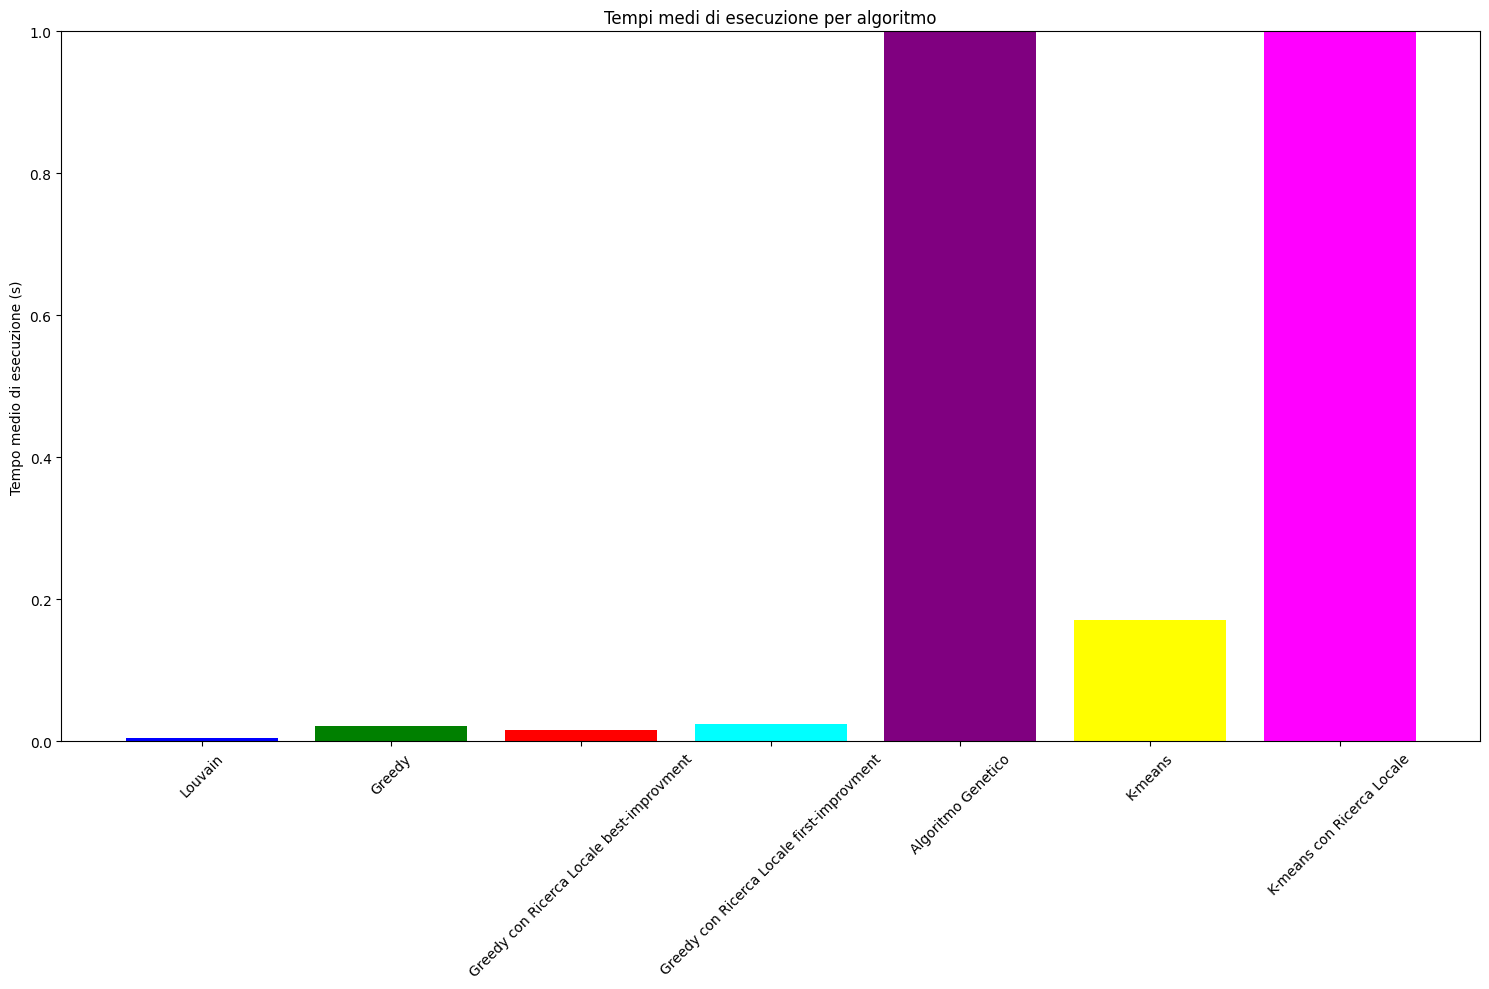

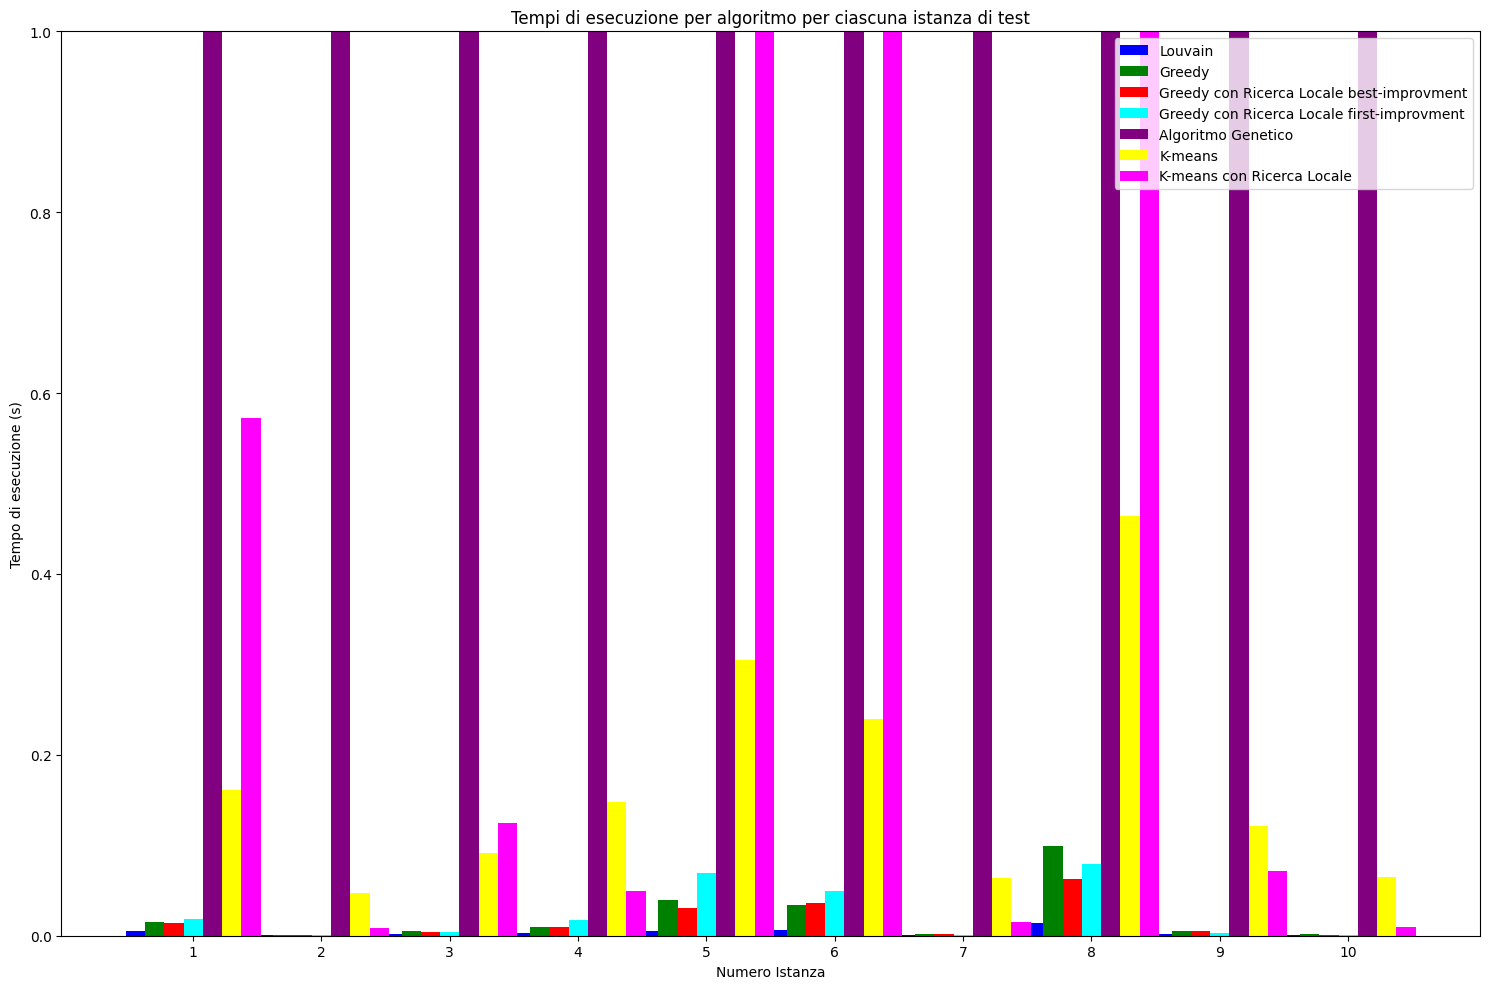

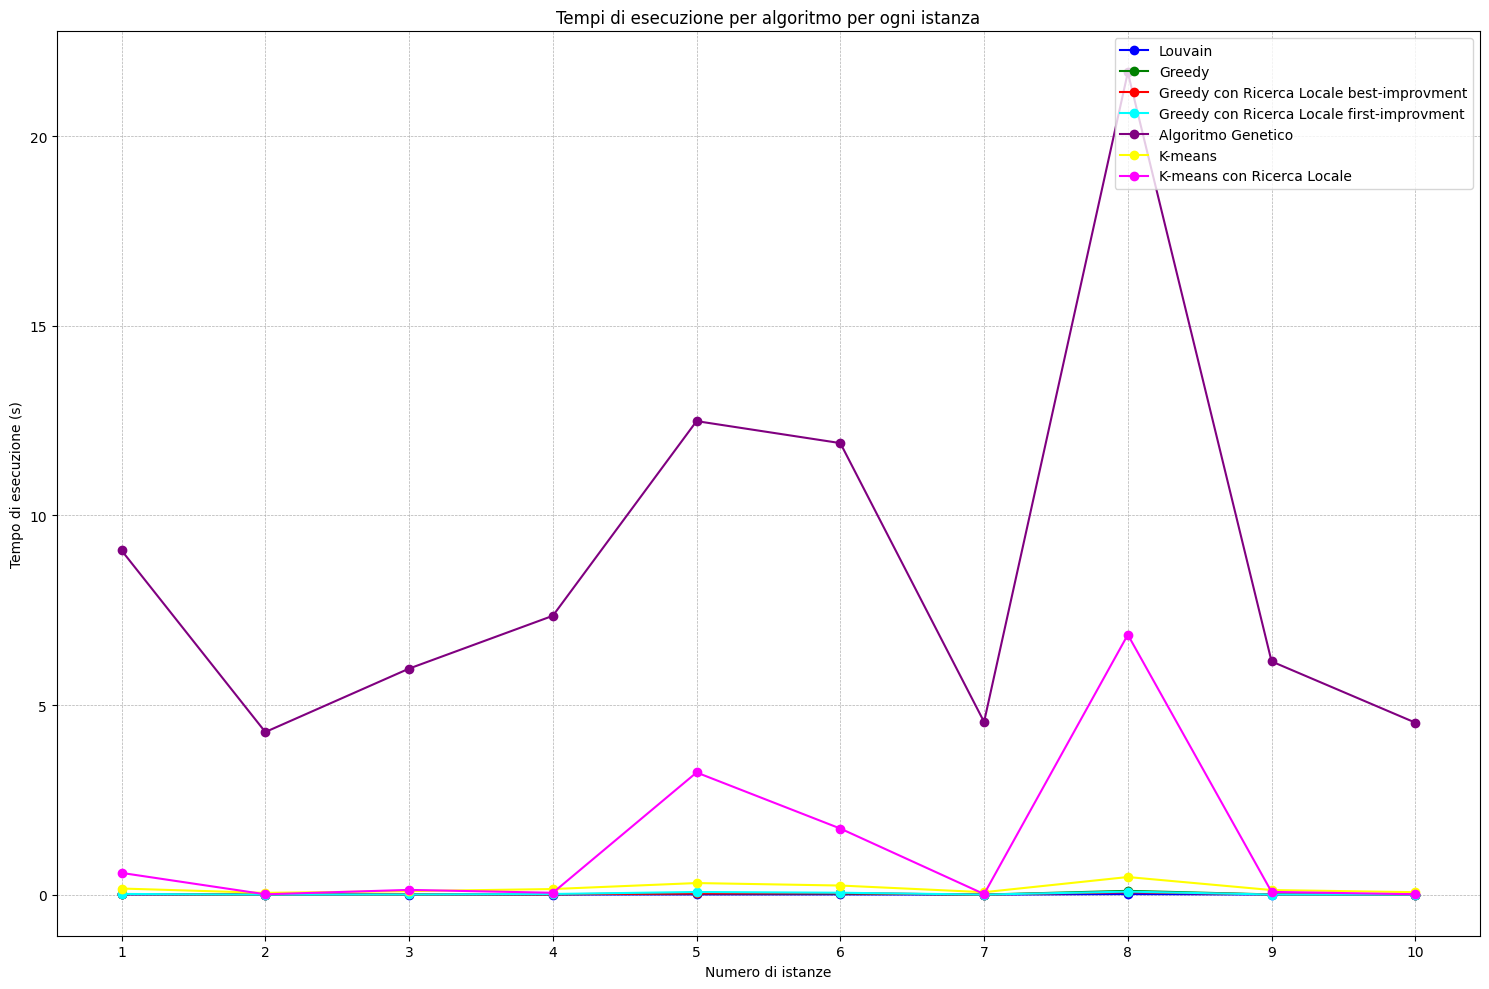

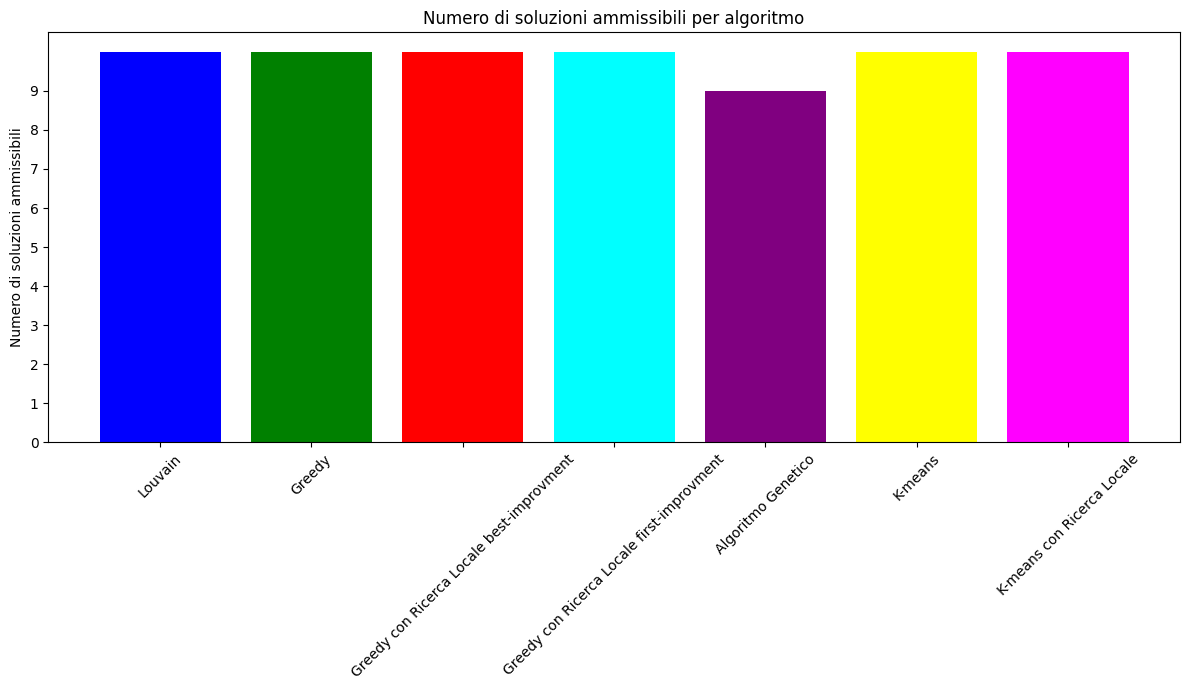

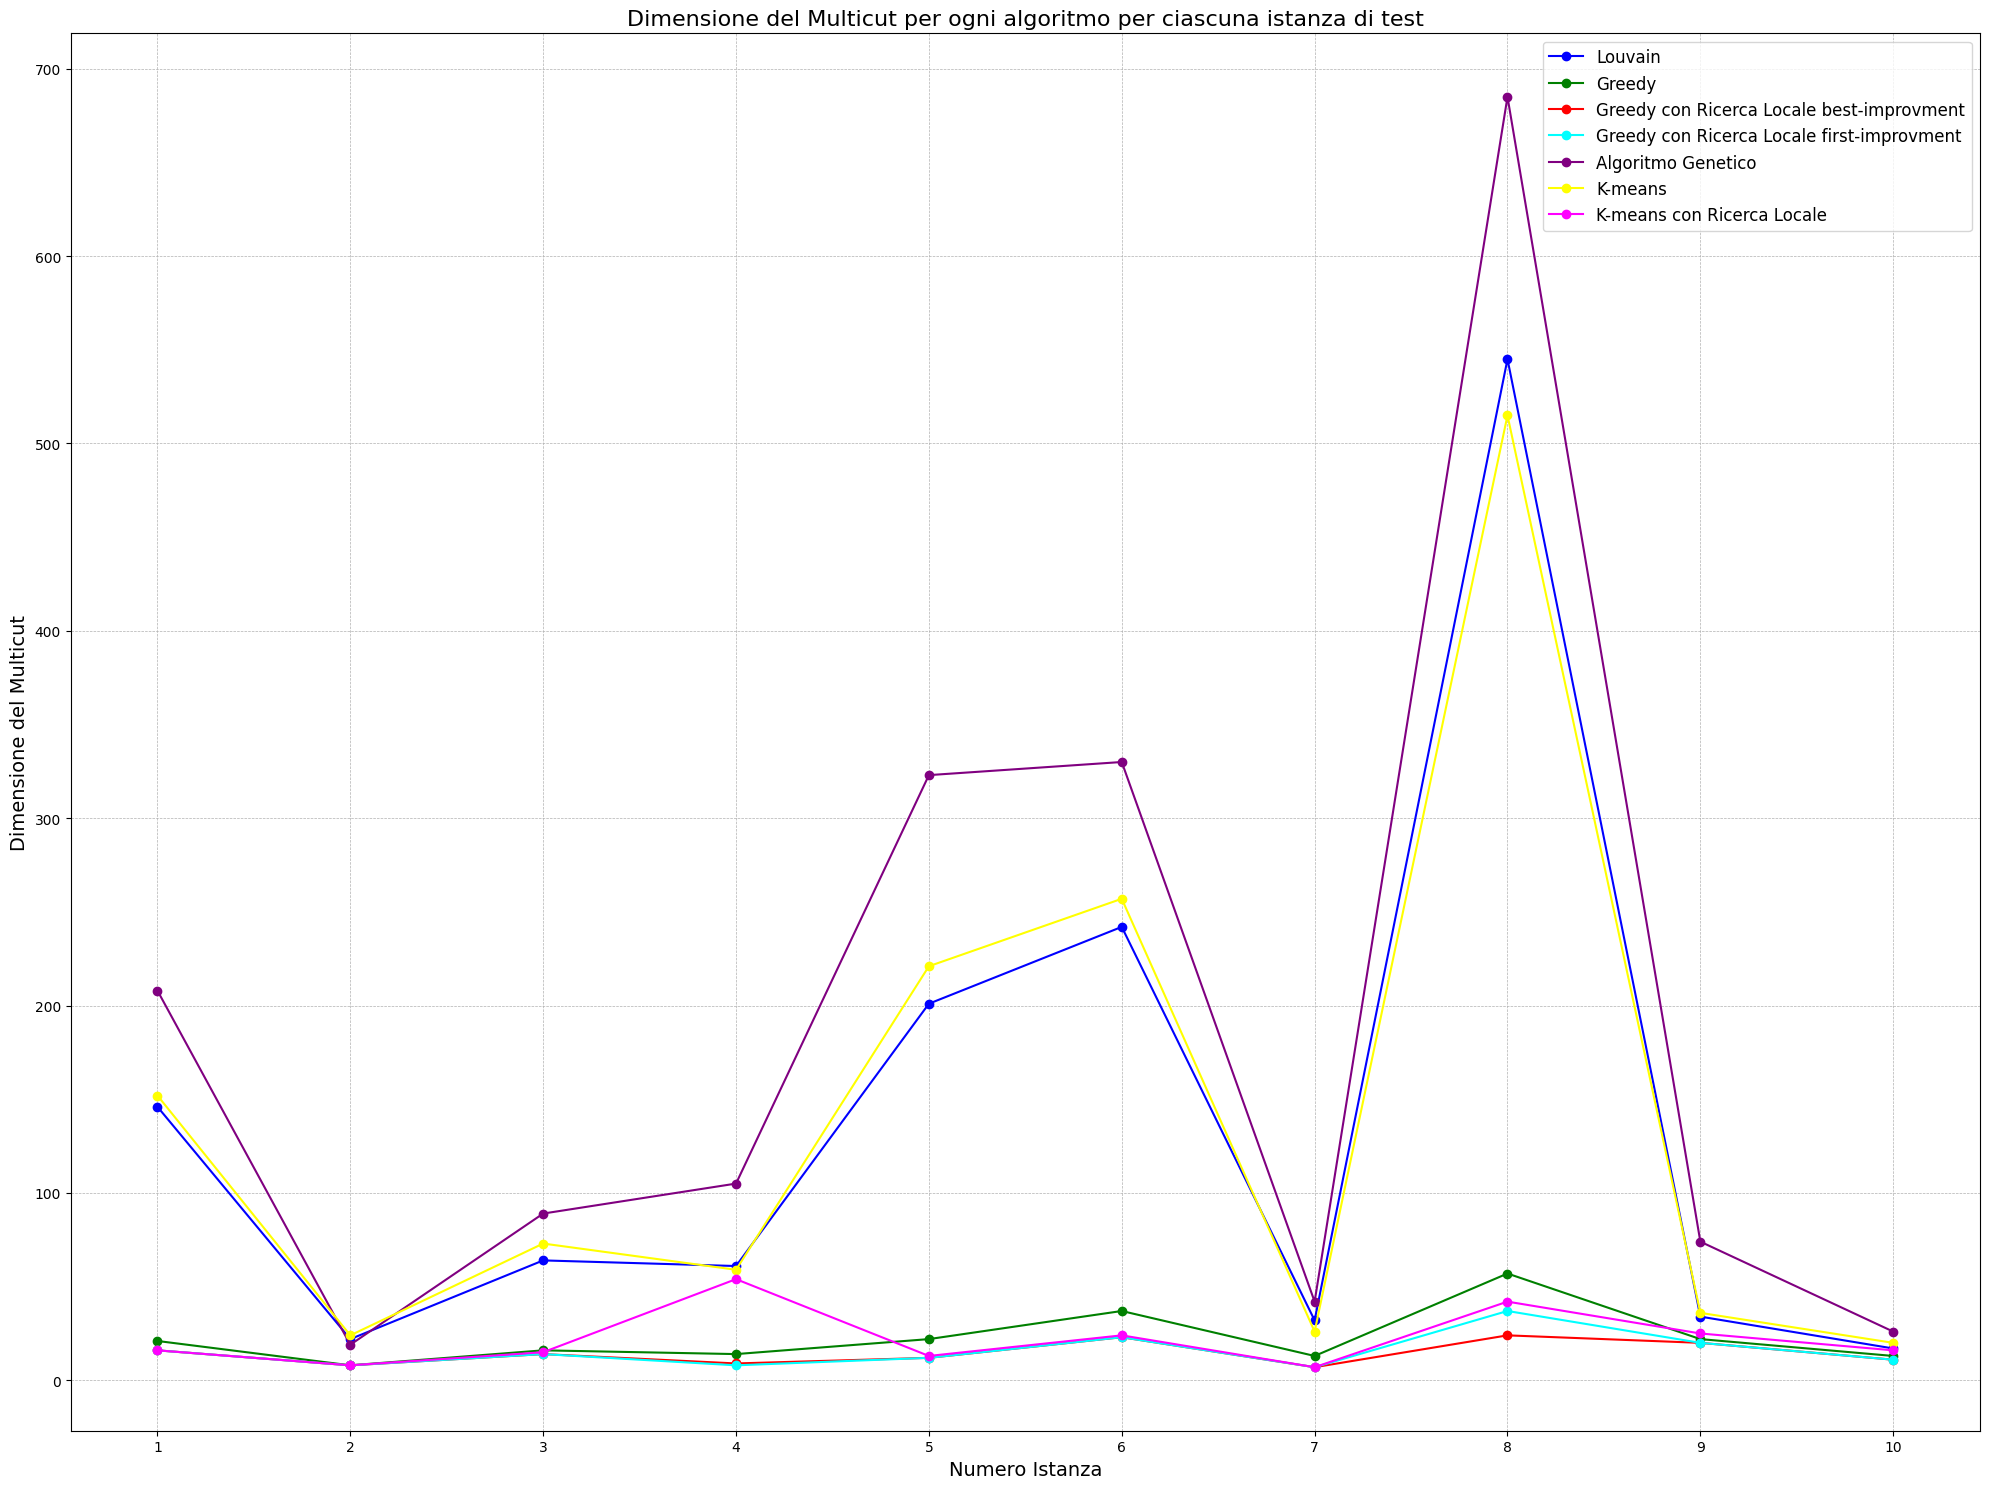

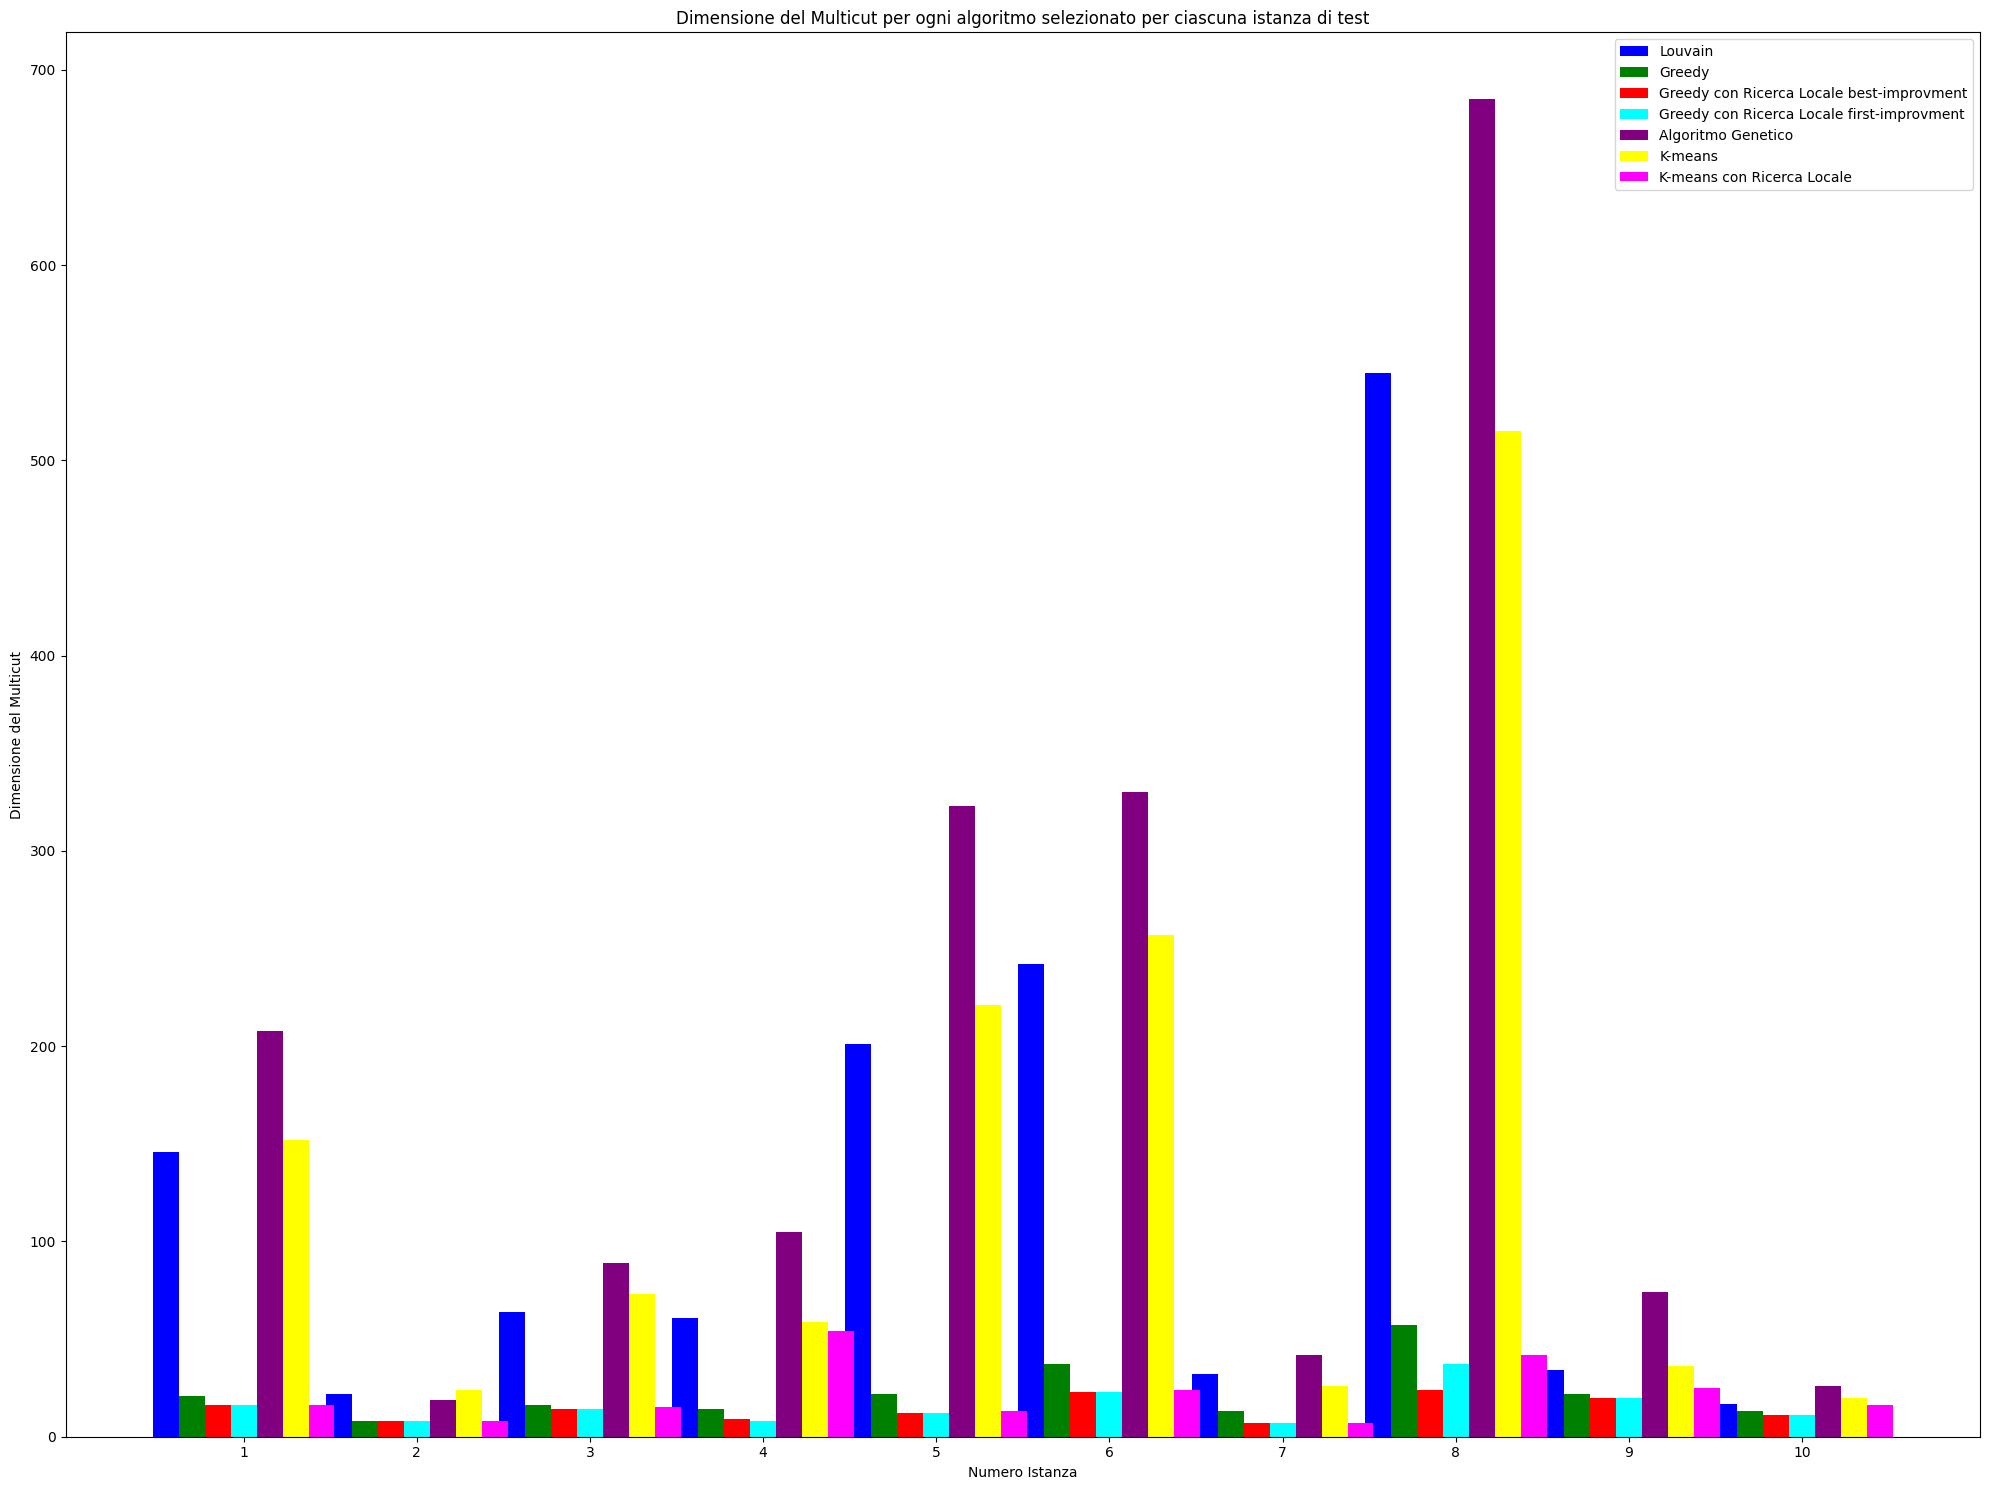

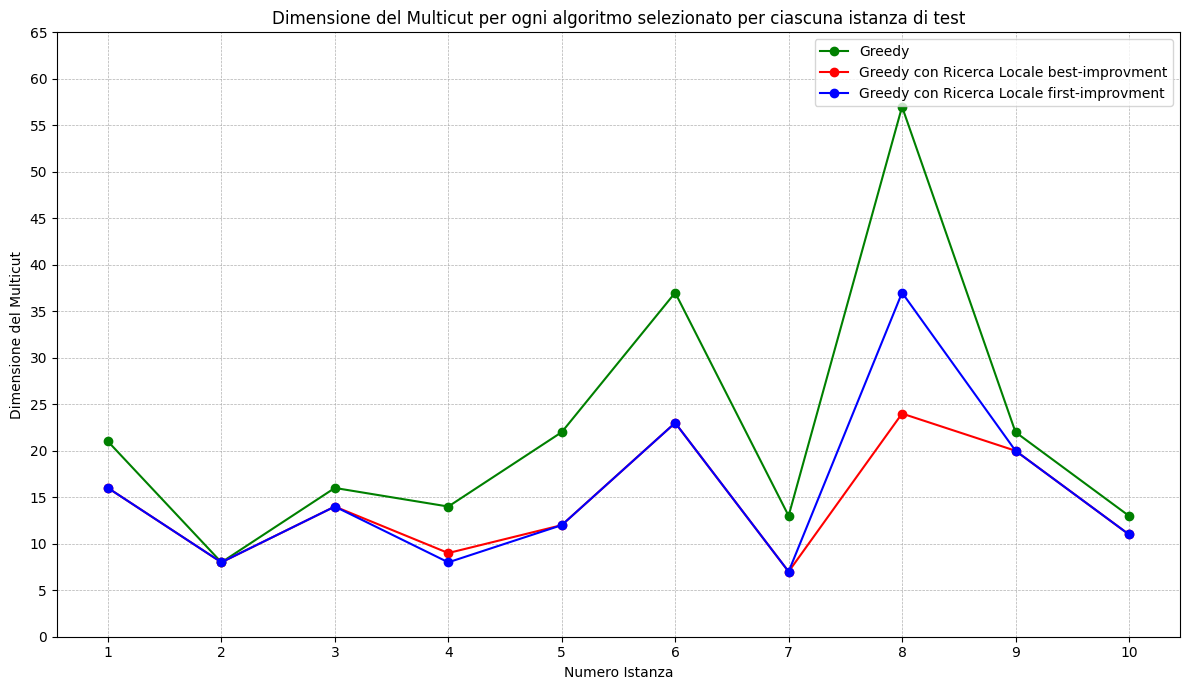

In [160]:

def calcola_dimensione_multicut(grafo, clusters):
    if not all(isinstance(cluster, (list, set, tuple)) for cluster in clusters):
        raise ValueError("Si prevede che 'clusters' sia una lista di iterabili (list, set, tuple).")

    multicut_size = 0

    # Crea un dizionario per mappare i nodi ai loro cluster
    etichette_cluster = {}
    for etichetta, cluster in enumerate(clusters):
        for nodo in cluster:
            etichette_cluster[nodo] = etichetta

    for arco in grafo.edges():
        if etichette_cluster[arco[0]] != etichette_cluster[arco[1]]:
            multicut_size += 1

    return multicut_size

def genera_grafo_random(n, p):
    
    # Genera un grafo random con n nodi che è garantito essere connesso.
    # Ogni possibile arco aggiuntivo è presente con probabilità p.
    
    grafo = Graph()

    # Aggiungiamo i vertici al grafo
    for i in range(n):
        grafo.aggiungi_vertice(i)

    # Assicuriamoci che il grafo sia connesso creando una catena di nodi
    for i in range(n-1):
        grafo.aggiungi_arco(i, i+1)

    # Aggiungiamo gli archi al grafo con probabilità p
    for i in range(n):
        for j in range(i+2, n):  # Iniziamo da i+2 perché i nodi i e i+1 sono già connessi
            if random.random() < p:
                grafo.aggiungi_arco(i, j)

    return grafo


def converti_a_networkx(grafo_personalizzato):
    G = nx.Graph()
    for nodo, adiacenti in grafo_personalizzato.grafo.items():
        G.add_node(nodo)
        for adiacente in adiacenti:
            G.add_edge(nodo, adiacente)
    return G



def genera_istanze(n_istanze=40):
    istanze = []
    
    # Utilizzando la funzione genera_grafo_random:
    for _ in range(n_istanze):
        n = random.randint(10, 100)  # numero di nodi
        p = random.uniform(0.05, 0.3)  # probabilità di un arco tra due nodi
        G_random_personalizzato = genera_grafo_random(n, p)
        G_random = converti_a_networkx(G_random_personalizzato)  # Convertiamo il grafo personalizzato in uno di networkx
        istanze.append(G_random)
    
    return istanze





def main():
    k = 4  # Numero di clusters desiderato
    istanze_di_test = genera_istanze( n_istanze=10)
    
    ammissibilita = {
        'Louvain': [],
        'Greedy': [],
        'Greedy con Ricerca Locale best-improvment': [],
        'Greedy con Ricerca Locale first-improvment': [],
        'Algoritmo Genetico': [],
        'K-means': [],
        'K-means con Ricerca Locale': []
    }

    tempi_esecuzione = {
        'Louvain': [],
        'Greedy': [],
        'Greedy con Ricerca Locale best-improvment': [],
        'Greedy con Ricerca Locale first-improvment': [],
        'Algoritmo Genetico': [],
        'K-means': [],
        'K-means con Ricerca Locale': []
    }
    
    multicuts = {
        'Louvain': [],
        'Greedy': [],
        'Greedy con Ricerca Locale best-improvment': [],
        'Greedy con Ricerca Locale first-improvment': [],
        'Algoritmo Genetico': [],
        'K-means': [],
        'K-means con Ricerca Locale': []
    }


    for idx, grafo in enumerate(istanze_di_test):
        print(f"Istanza {idx+1}:")

        # Louvain
        start_time = time.time()
        partition = divide_into_clusters_fixed_k(grafo, k)
        
        end_time_louvain = time.time() - start_time
        clusters_louvain = [cluster for cluster in partition]


        multicut_louvain = calcola_dimensione_multicut(grafo, clusters_louvain)
        ammissibile_louvain = è_ammissibile(grafo, clusters_louvain, k)
        if not ammissibile_louvain:
            print("Louvain ha prodotto una soluzione non ammissibile!")
        # plot_graph(grafo, f"Istanza {idx+1} - Algoritmo Louvain", filename=f'output_istanza_{idx+1}_louvain.png', colors=clusters_louvain)
        print(f"  - Louvain: {end_time_louvain:.4f} secondi, Dimensione Multicut: {multicut_louvain}, Ammissibile: {ammissibile_louvain}")

        # Greedy
        start_time = time.time()
        clusters_greedy = divide_into_clusters_greedy(grafo, k)

        end_time_greedy = time.time() - start_time
        multicut_greedy = calcola_dimensione_multicut(grafo, clusters_greedy)
        ammissibile_greedy = è_ammissibile(grafo, clusters_greedy, k)
        if not ammissibile_greedy:
            print("Greedy ha prodotto una soluzione non ammissibile!")
        #plot_graph(grafo, f"Istanza {idx+1} - Greedy", filename=f'output_istanza_{idx+1}_greedy.png', colors=clusters_greedy)
        print(f"  - Greedy: {end_time_greedy:.4f} secondi, Dimensione Multicut: {multicut_greedy}, Ammissibile: {ammissibile_greedy}")

        # Greedy con Ricerca Locale approccio best-improvment
        clusters_greedy_ricerca_locale_1 = [set(cluster) for cluster in clusters_greedy] # prendi l'output della tua funzione greedy come inizio
        start_time = time.time()
        final_clusters_1 = local_search_improve(grafo, clusters_greedy_ricerca_locale_1)
        end_time_greedy_ricerca_locale_1 = time.time() - start_time

        multicut_greedy_ricerca_locale_1 = evaluate_solution(final_clusters_1, grafo)  # usa final_clusters non clusters_greedy_ricerca_locale
        ammissibile_greedy_ricerca_locale_1, motivo = è_ammissibile(grafo, final_clusters_1, k) # usa final_clusters non clusters_greedy_ricerca_locale e k è stato sostituito con 3 perché hai fornito quel valore prima
        if not ammissibile_greedy_ricerca_locale_1:
            print(f"Greedy con Ricerca Locale best-improvment ha prodotto una soluzione non ammissibile! Motivo: {motivo}")
        #plot_graph(grafo, f"Istanza {idx+1} - Greedy con Ricerca Locale", filename=f'output_istanza_{idx+1}_greedy_ricerca_locale.png', colors=final_clusters)
        print(f"  - Greedy con Ricerca Locale best-improvment: {end_time_greedy_ricerca_locale_1:.4f} secondi, Dimensione Multicut: {multicut_greedy_ricerca_locale_1}, Ammissibile: {ammissibile_greedy_ricerca_locale_1}")



        # Greedy con Ricerca Locale approccio first-improvment
        clusters_greedy_ricerca_locale_2 = [set(cluster) for cluster in clusters_greedy] # prendi l'output della tua funzione greedy come inizio
        start_time = time.time()
        final_clusters_2 = local_search_first(grafo, clusters_greedy_ricerca_locale_2)
        end_time_greedy_ricerca_locale_2 = time.time() - start_time

        multicut_greedy_ricerca_locale_2 = evaluate_solution(final_clusters_2, grafo)  # usa final_clusters non clusters_greedy_ricerca_locale
        ammissibile_greedy_ricerca_locale_2, motivo = è_ammissibile(grafo, final_clusters_2, k) # usa final_clusters non clusters_greedy_ricerca_locale e k è stato sostituito con 3 perché hai fornito quel valore prima
        if not ammissibile_greedy_ricerca_locale_2:
            print(f"Greedy con Ricerca Locale first-improvment ha prodotto una soluzione non ammissibile! Motivo: {motivo}")
        #plot_graph(grafo, f"Istanza {idx+1} - Greedy con Ricerca Locale", filename=f'output_istanza_{idx+1}_greedy_ricerca_locale.png', colors=final_clusters)
        print(f"  - Greedy con Ricerca Locale first-improvment: {end_time_greedy_ricerca_locale_2:.4f} secondi, Dimensione Multicut: {multicut_greedy_ricerca_locale_2}, Ammissibile: {ammissibile_greedy_ricerca_locale_2}")

        # Algoritmo Genetico 
        start_time = time.time()
        clusters_genetico = genetic_algorithm(grafo, k)
        end_time_genetico = time.time() - start_time
        multicut_genetico = calcola_dimensione_multicut(grafo, clusters_genetico)
        ammissibile_genetico = è_ammissibile(grafo, clusters_genetico, k)
        if not ammissibile_genetico:
            print("L'Algoritmo Genetico ha prodotto una soluzione non ammissibile!")
        # plot_graph(grafo, f"Istanza {idx+1} - Algoritmo Genetico", filename=f'output_istanza_{idx+1}_genetico.png', colors=clusters_genetico)
        print(f"  - Algoritmo Genetico: {end_time_genetico:.4f} secondi, Dimensione Multicut: {multicut_genetico}, Ammissibile: {ammissibile_genetico}")
        
        
        # K-means 
        start_time = time.time()

        nodes, embeddings = node_representation(grafo)
        clusters_dict = kmeans_clustering(nodes, embeddings, k)
        clusters_list = [clusters_dict[key] for key in clusters_dict]
        optimized_clusters = minimize_multicut(grafo, clusters_dict)
        optimized_clusters_list = [optimized_clusters[key] for key in optimized_clusters]
        end_time_kmeans = time.time() - start_time

        multicut_kmeans = calcola_dimensione_multicut(grafo, optimized_clusters_list)
        ammissibile_kmeans, msg_kmeans = è_ammissibile(grafo, optimized_clusters_list, k)

        if not ammissibile_kmeans:
            print("K-means ha prodotto una soluzione non ammissibile!")

        # plot_graph(grafo, f"Istanza {idx+1} - K-means", filename=f'output_istanza_{idx+1}_kmeans.png', colors=optimized_clusters_list)

        print(f"  - K-means: {end_time_kmeans:.4f} secondi, Dimensione Multicut: {multicut_kmeans}, Ammissibile: {msg_kmeans}")

        # k_means_on_graph con Ricerca Locale
        start_time = time.time()
        clusters_ricerca_locale_list = best_improvement_local_search(clusters_list.copy(), grafo, k)
        end_time_k_means_ricerca_locale = time.time() - start_time

        multicut_k_means_ricerca_locale = calcola_dimensione_multicut(grafo, clusters_ricerca_locale_list)
        ammissibile_k_means_ricerca_locale = è_ammissibile(grafo, clusters_ricerca_locale_list, k)

        
        if not ammissibile_k_means_ricerca_locale:
            print("k_means_on_graph con Ricerca Locale ha prodotto una soluzione non ammissibile!")
        
        # plot_graph(grafo, f"Istanza {idx+1} - k_means_on_graph con Ricerca Locale", filename=f'output_istanza_{idx+1}_k_means_ricerca_locale.png', colors=clusters_ricerca_locale_list)
        print(f"  - k_means_on_graph con Ricerca Locale: {end_time_k_means_ricerca_locale:.4f} secondi, Dimensione Multicut: {multicut_k_means_ricerca_locale}, Ammissibile: {ammissibile_k_means_ricerca_locale[1]}")

        # After each algorithm's solution and time measurement
        
        ammissibilita['Louvain'].append(ammissibile_louvain)
        ammissibilita['Greedy'].append(ammissibile_greedy)
        ammissibilita['Greedy con Ricerca Locale best-improvment'].append(ammissibile_greedy_ricerca_locale_1)
        ammissibilita.setdefault('Greedy con Ricerca Locale first-improvment', []).append(ammissibile_greedy_ricerca_locale_2)
        ammissibilita['Algoritmo Genetico'].append(ammissibile_genetico)
        ammissibilita['K-means'].append(ammissibile_kmeans)
        ammissibilita['K-means con Ricerca Locale'].append(ammissibile_k_means_ricerca_locale[0])
        
        tempi_esecuzione['Louvain'].append(end_time_louvain)
        tempi_esecuzione['Greedy'].append(end_time_greedy)
        tempi_esecuzione['Greedy con Ricerca Locale best-improvment'].append(end_time_greedy_ricerca_locale_1)
        tempi_esecuzione['Greedy con Ricerca Locale first-improvment'].append(end_time_greedy_ricerca_locale_2)
        tempi_esecuzione['Algoritmo Genetico'].append(end_time_genetico)
        tempi_esecuzione['K-means'].append(end_time_kmeans)
        tempi_esecuzione['K-means con Ricerca Locale'].append(end_time_k_means_ricerca_locale)
        
        multicuts['Louvain'].append(multicut_louvain)
        multicuts['Greedy'].append(multicut_greedy)
        multicuts['Greedy con Ricerca Locale best-improvment'].append(multicut_greedy_ricerca_locale_1)
        multicuts['Greedy con Ricerca Locale first-improvment'].append(multicut_greedy_ricerca_locale_2)
        multicuts['Algoritmo Genetico'].append(multicut_genetico)
        multicuts['K-means'].append(multicut_kmeans)
        multicuts['K-means con Ricerca Locale'].append(multicut_k_means_ricerca_locale)
        
    #for key, value in ammissibilita.items():
        #print(key, value)

    # Calculate the efficiencies
    efficienze = {
        key: (1 - sum(1 for sub_tuple in value if isinstance(sub_tuple, (tuple, list)) and sub_tuple[0]) / len(istanze_di_test)) * 100
        for key, value in ammissibilita.items()
    }





# Initialize the efficiencies dictionary
    efficienze = {
        'Louvain': 0,
        'Greedy': 0,
        'Greedy con Ricerca Locale best-improvment': 0,
        'Greedy con Ricerca Locale first-improvment': 0,
        'Algoritmo Genetico': 0,
        'K-means': 0  ,
        'K-means con Ricerca Locale': 0
    }

    for idx, grafo in enumerate(istanze_di_test):
        #print(f"Istanza {idx+1}:")


        efficienze['Louvain'] += end_time_louvain
        efficienze['Greedy'] += end_time_greedy
        efficienze['Greedy con Ricerca Locale best-improvment'] += end_time_greedy_ricerca_locale_1
        efficienze['Greedy con Ricerca Locale first-improvment'] += end_time_greedy_ricerca_locale_2
        efficienze['Algoritmo Genetico'] += end_time_genetico
        efficienze['K-means'] += end_time_kmeans
        efficienze['K-means con Ricerca Locale'] += end_time_k_means_ricerca_locale


    # Normalizza i tempi per trasformarli in efficienze
    total_time = sum(efficienze.values())
    for key in efficienze:
        efficienze[key] = (1 - efficienze[key] / total_time) * 100




    algoritmi = list(tempi_esecuzione.keys())
    colori = ['blue', 'green', 'red', 'cyan', 'purple', 'yellow',  'magenta', 'pink']

    # Calcola il tempo medio di esecuzione per ogni algoritmo
    tempi_medi = {algo: sum(tempi) / len(tempi) for algo, tempi in tempi_esecuzione.items()}
    #tempi_medi = {algo: sum(tempi) / len(tempi) for algo, tempi in tempi_esecuzione.items()}
    plt.figure(figsize=(15, 10))
    plt.bar(tempi_medi.keys(), tempi_medi.values(), color=colori)
    plt.ylabel('Tempo medio di esecuzione (s)')
    plt.title('Tempi medi di esecuzione per algoritmo')
    plt.xticks(rotation=45)
    plt.ylim(0, 1)  # Limita l'asse y a valori compresi tra 0 e 0.05
    # plt.yticks(range(0, 101, 10))
    plt.tight_layout()
    plt.show()
    
    
    bar_width = 0.15
    index = np.arange(len(istanze_di_test))
    plt.figure(figsize=(15, 10))
    for idx, algo in enumerate(algoritmi):
        plt.bar(index + idx * bar_width, tempi_esecuzione[algo], bar_width, color=colori[idx], label=algo)

    plt.xlabel('Numero Istanza')
    plt.ylabel('Tempo di esecuzione (s)')
    plt.title('Tempi di esecuzione per algoritmo per ciascuna istanza di test')
    plt.xticks(index + bar_width * (len(algoritmi) - 1) / 2, range(1, len(istanze_di_test) + 1))
    plt.ylim(0, 1)  # Limita l'asse y a valori compresi tra 0 e 0.05
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()
    
    
    
    
    # Grafico che mostra i tempi di esecuzione per ogni istanza
    plt.figure(figsize=(15, 10))
    
    for idx, algo in enumerate(algoritmi):
        plt.plot(range(1, len(istanze_di_test)+1), tempi_esecuzione[algo], marker='o', color=colori[idx], label=algo)
        
    plt.xlabel('Numero di istanze')
    plt.ylabel('Tempo di esecuzione (s)')
    plt.title('Tempi di esecuzione per algoritmo per ogni istanza')
    plt.xticks(range(1, len(istanze_di_test)+1))
    plt.legend(loc='upper right')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

    # Grafico che mostra il numero di soluzioni ammissibili per ogni algoritmo
    conteggio_ammissibilita = {k: sum(1 for val in v if val == True or (isinstance(val, tuple) and val[0])) for k, v in ammissibilita.items()}
    plt.figure(figsize=(12, 7))
    plt.bar(conteggio_ammissibilita.keys(), conteggio_ammissibilita.values(), color=colori)
    plt.ylabel('Numero di soluzioni ammissibili')
    plt.title('Numero di soluzioni ammissibili per algoritmo')
    plt.xticks(rotation=45)
    plt.yticks(range(0, 10, 1))
    plt.tight_layout()
    plt.show()
    
  

    # Grafico che mostra il dimensione del multiut per ogni istanza
    plt.figure(figsize=(20, 15))

    for idx, algo in enumerate(algoritmi):
        plt.plot(range(1, len(istanze_di_test) + 1), multicuts[algo], marker='o', color=colori[idx], label=algo)

    plt.xlabel('Numero Istanza', fontsize=14)
    plt.ylabel('Dimensione del Multicut', fontsize=14)
    plt.title('Dimensione del Multicut per ogni algoritmo per ciascuna istanza di test', fontsize=16)
    plt.xticks(range(1, len(istanze_di_test) + 1))

    plt.legend(loc='upper right', fontsize=12)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

    
    # Grafico a barre della dimensione del multicut per ogni istanza e per ogni algoritmo selezionato
    bar_width = 0.15
    index = np.arange(len(istanze_di_test))

    plt.figure(figsize=(20, 15))
    for idx, algo in enumerate(algoritmi):
        plt.bar(index + idx * bar_width, multicuts[algo], bar_width, color=colori[idx], label=algo)

    plt.xlabel('Numero Istanza')
    plt.ylabel('Dimensione del Multicut')
    plt.title('Dimensione del Multicut per ogni algoritmo selezionato per ciascuna istanza di test')
    plt.xticks(index + bar_width * (len(algoritmi) - 1) / 2, range(1, len(istanze_di_test) + 1))

    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()


    # Lista degli algoritmi e dei colori selezionati
    algoritmi_confrontati = ['Greedy', 'Greedy con Ricerca Locale best-improvment','Greedy con Ricerca Locale first-improvment']
    colori = ['green', 'red', 'blue']

    # 1. Grafico che mostra la dimensione del multicut per ogni algoritmo selezionato per ciascuna delle istanze di test.
    plt.figure(figsize=(12, 7))
    for idx, algo in enumerate(algoritmi_confrontati):
        plt.plot(range(1, len(istanze_di_test) + 1), multicuts[algo], marker='o', color=colori[idx], label=algo)

    plt.xlabel('Numero Istanza')
    plt.ylabel('Dimensione del Multicut')
    plt.title('Dimensione del Multicut per ogni algoritmo selezionato per ciascuna istanza di test')
    plt.xticks(range(1, len(istanze_di_test) + 1))
    plt.yticks(range(0, 70, 5))
    plt.legend(loc='upper right')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

 
